In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score

In [2]:
news_dataset = pd.read_csv('train.csv')
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


label
0    10387
1    10413
Name: label, dtype: int64


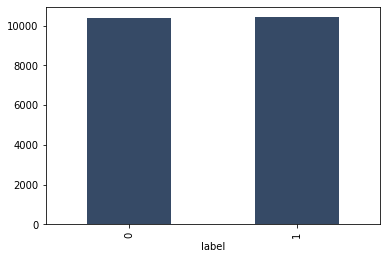

In [3]:
print(news_dataset.groupby(['label'])['label'].count())
news_dataset.groupby(['label'])['label'].count().plot(kind="bar", color="#364a66")
plt.show()

## Preprocess Text

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# text word count
news_dataset['word_count'] = news_dataset['text'].apply(lambda x: len(str(x).split()))
print(news_dataset[news_dataset['label']==1]['word_count'].mean()) # fake articles
print(news_dataset[news_dataset['label']==0]['word_count'].mean()) # reliable articles

639.0722174205321
878.9965341292


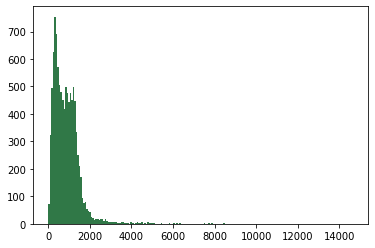

Number of real articles with zero words:  0


In [7]:
x = news_dataset[news_dataset['label']==0]['word_count']
plt.hist(x, bins = 200, color="#307847")
plt.show() 
print("Number of real articles with zero words: ", len(news_dataset[(news_dataset['label']==0) & (news_dataset['word_count']==0)])) 

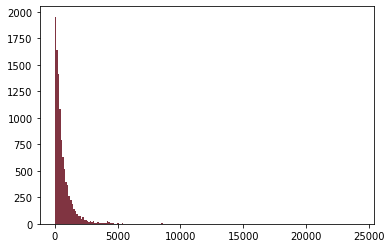

Number of real articles with zero words:  77


In [8]:
x = news_dataset[news_dataset['label']==1]['word_count']
plt.hist(x, bins = 200, color="#803441")
plt.show()
print("Number of real articles with zero words: ", len(news_dataset[(news_dataset['label']==1) & (news_dataset['word_count']==0)])) 

In [9]:
news_dataset = news_dataset.fillna('')
news_dataset['article'] = news_dataset['author'] + ' ' + news_dataset['title']

In [26]:
news_dataset['Avg_length'] = news_dataset["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))
print(news_dataset[news_dataset['label'] == 1]['Avg_length'].mean())
print(news_dataset[news_dataset['label'] == 0]['Avg_length'].mean())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


5.119332276011902
4.932543698593878


In [11]:
ps = PorterStemmer()

def preprocess(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stop_words and len(word) > 2]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content 

In [12]:
news_dataset['article'] = news_dataset['article'].apply(preprocess)  

In [13]:
# Most frequent words in real articles
real = news_dataset[news_dataset['label'] == 0]['article'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(real) if i.lower() not in stop_words and i.isalpha()]
wordfreqreal = nltk.FreqDist(list_of_words)
mostcommonreal = wordfreqreal.most_common(30)
print(mostcommonreal)

[('new', 6726), ('time', 6420), ('york', 6385), ('breitbart', 2752), ('trump', 2274), ('donald', 639), ('michael', 438), ('john', 423), ('say', 392), ('news', 326), ('obama', 300), ('clinton', 293), ('charli', 272), ('key', 269), ('state', 260), ('presid', 256), ('pam', 252), ('attack', 246), ('hous', 246), ('report', 243), ('brief', 237), ('hillari', 215), ('daniel', 206), ('year', 199), ('even', 198), ('bill', 194), ('white', 192), ('kill', 190), ('ian', 185), ('call', 185)]


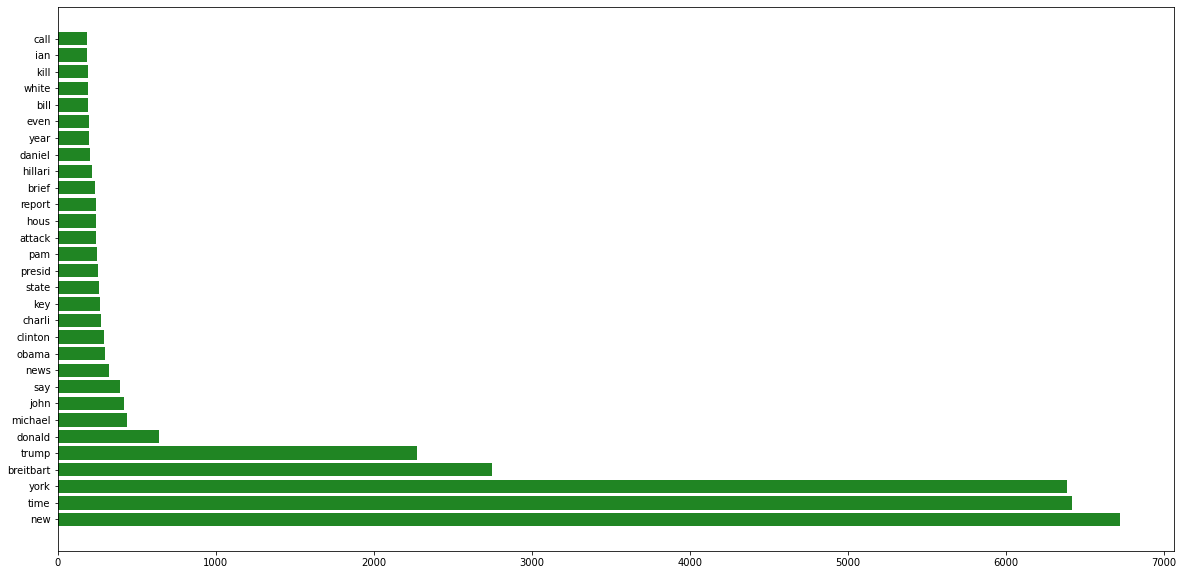

In [14]:
plt.figure(figsize=(20,10)) 
plt.barh(range(len(mostcommonreal)),[val[1] for val in mostcommonreal], align='center', color="#208523")
plt.yticks(range(len(mostcommonreal)), [val[0] for val in mostcommonreal])
plt.show()

In [15]:
# Most frequent words in fake articles
fake = news_dataset[news_dataset['label'] == 1]['text'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(fake) if i.lower() not in stop_words and i.isalpha()]
wordfreqfake = nltk.FreqDist(list_of_words)
mostcommonfake = wordfreqfake.most_common(30)
print(mostcommonfake)

[('trump', 20147), ('clinton', 19254), ('people', 16598), ('one', 16126), ('us', 14921), ('would', 14555), ('hillary', 12762), ('said', 11875), ('new', 10395), ('like', 10319), ('also', 9921), ('time', 9235), ('world', 9180), ('state', 8906), ('even', 8856), ('president', 8508), ('election', 8263), ('government', 8145), ('many', 7967), ('war', 7625), ('obama', 7547), ('could', 7448), ('american', 6976), ('u', 6936), ('russia', 6742), ('states', 6567), ('media', 6544), ('de', 6525), ('years', 6472), ('first', 6327)]


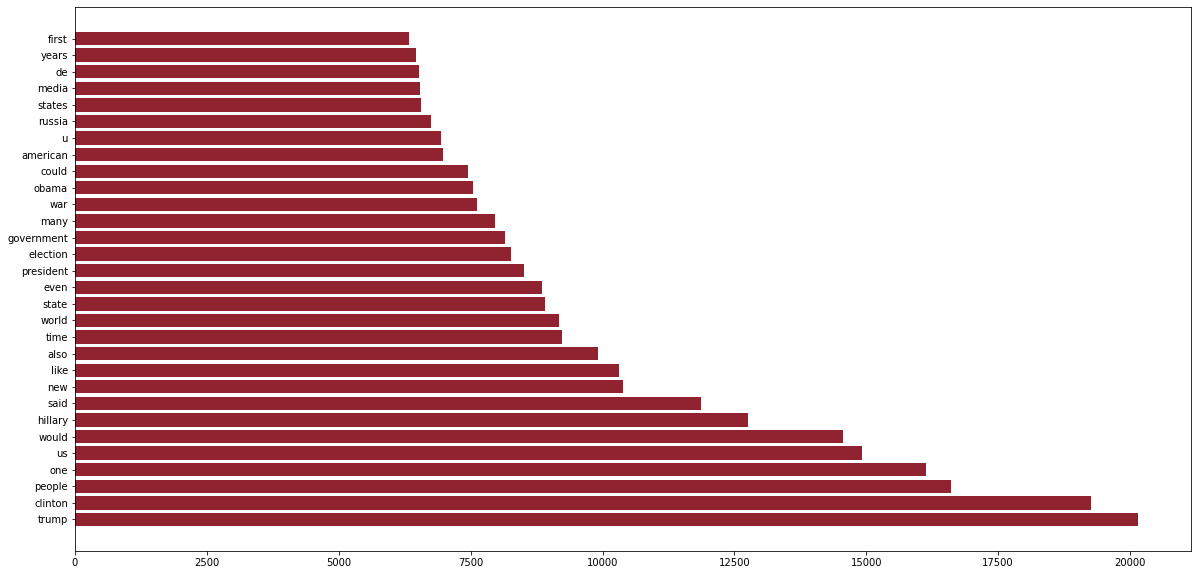

In [16]:
plt.figure(figsize=(20,10)) 
plt.barh(range(len(mostcommonfake)),[val[1] for val in mostcommonfake], align='center', color="#912330")
plt.yticks(range(len(mostcommonfake)), [val[0] for val in mostcommonfake])
plt.show()

In [17]:
content= news_dataset['article'].values
labels = news_dataset['label'].values
print(news_dataset['article'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel flynn flynn hillari clinton big woman c...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl airstrik i...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman playoff schedul matchup odd n...
20797    michael merc rachel abram maci said receiv tak...
20798    alex ansari nato russia hold parallel exercis ...
20799                              david swanson keep aliv
Name: article, Length: 20800, dtype: object


In [18]:
#from text to numeric
# get tfidf values
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(content)
content = tfidfvectorizer.transform(content) 

## Training

In [19]:
model = svm.SVC()

In [20]:
model.fit(content, labels)

SVC()

In [21]:
trainPrediction = model.predict(content)
trainingAccuracy = accuracy_score(trainPrediction, labels)

In [22]:
print('Training data accuracy: ', trainingAccuracy)

Training data accuracy:  0.9989423076923077


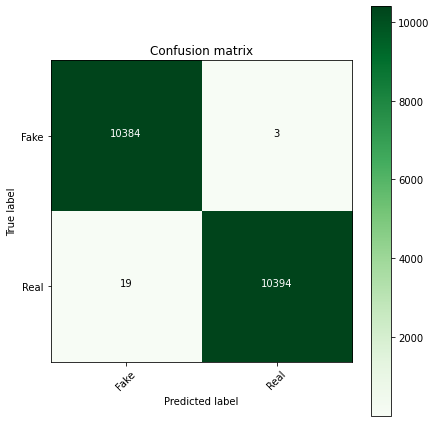

In [23]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(labels, trainPrediction)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Running model on test.csv

In [24]:
testdata = pd.read_csv('test.csv')

testdata.isnull().sum()
testdata = testdata.fillna('') 

testdata['content'] = testdata['author']+' '+testdata['title'] 

testdata['content'] = testdata['content'].apply(preprocess) 
testdatavalues = testdata['content'].values 
  
newcontent = tfidfvectorizer.transform(testdatavalues) 
testdata['label'] = model.predict(newcontent)

In [25]:
newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1
